In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sn


In [2]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0.1}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [3]:
# Experiment hyperparamters
rng = np.random.RandomState(42)
split_on_income = False  # if True: src := income>=50k, tgt :+ income<50k, if False: src := male, tgt := female
n_samples = 1000

In [4]:
comparison_id = None

In [5]:
# Parameters
comparison_id = 1


In [6]:

# Load the data
comparison_dict = {0: [0,1], 1: [2,3], 2: [4,5]}
path_customer_profiles = open('./Results_Experiments/File_Paths/path_customer_profiles.txt','r').read()
path_transport_graphics = open('./Results_Experiments/File_Paths/path_transport_graphics.txt','r').read()
source = pd.read_csv(f'../{path_customer_profiles}/customer_profile_{comparison_dict[comparison_id][0]}.csv')
target = pd.read_csv(f'../{path_customer_profiles}/customer_profile_{comparison_dict[comparison_id][1]}.csv')

feature_names = source.columns.values
feature_names = list(feature_names)
print(feature_names)

['Customer_id', 'Connection', 'Weight', 'Unit_type', 'Day', 'Week']


In [7]:
# standardize the source and target data, and convert to domain labels
from sklearn.preprocessing import StandardScaler
X = np.concatenate((source, target), axis=0)
# standardize X to remove cardinatlity bias
X = StandardScaler().fit_transform(X)
y = np.concatenate((np.zeros(source.shape[0]),
                    np.ones(target.shape[0])), axis=0)  # domain labels

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     stratify=y, random_state=42)

In [9]:
# Using XGBoost
import xgboost

def fit_xgboost(X_train, y_train, X_test, y_test, feature_names=None):
    """ Train an XGBoost model with early stopping.
    """
    dtrain = xgboost.DMatrix(X_train, label=y_train, feature_names=feature_names)
    dtest = xgboost.DMatrix(X_test, label=y_test, feature_names=feature_names)
    # model = xgboost.train(
    #     { "eta": 0.001, "subsample": 0.5, "max_depth": 2,
    #       "objective": 'binary:logistic', 'eval_metric': 'logloss'}, dtrain, num_boost_round=200000,
    #     evals=[(dtest,'eval'), (dtrain,'train')], early_stopping_rounds=20, verbose_eval=False
    # )
    model = xgboost.train(
        {"objective": 'binary:logistic', 'eval_metric': 'logloss'},
        dtrain,
        evals=[(dtest,'eval'), (dtrain,'train')],
        verbose_eval=False)
    return model

In [10]:
xgb_forest = fit_xgboost(X_train, y_train, X_test, y_test, feature_names)
xgb_forest.feature_names = feature_names

In [11]:
def get_acc(model, samples, labels, feature_names=None):
    predictions = (model.predict(xgboost.DMatrix(samples,
                                                 feature_names=feature_names)) > 0.5).astype(int)
    return (predictions == labels).sum() / predictions.shape[0]

In [12]:
print('Train score:', get_acc(xgb_forest, X_train, y_train, feature_names))
print('Test score:', get_acc(xgb_forest, X_test, y_test, feature_names))

Train score: 0.9263731656184486
Test score: 0.9250503018108652


In [13]:
import shap
import pandas as pd
explainer = shap.Explainer(xgb_forest)

shap_values = explainer(pd.DataFrame(X_test, columns=feature_names))


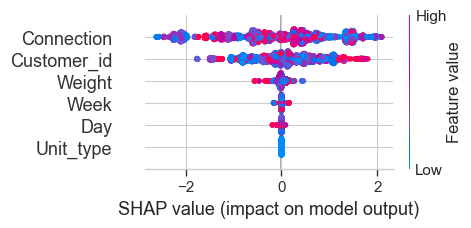

In [14]:
# Beeswarm plot

shap.plots.beeswarm(shap_values, show=False)
fig = plt.gcf()
fig.set_size_inches(4, 2, forward=True)
if save_figures: plt.savefig(
    f'../{path_transport_graphics}/logitics_data_on_customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}-shap-value.{save_parms["format"]}',
    **save_parms
    )
plt.show()